Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Prepare)

Today's guided module project will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills. The competition will begin

## Learning Objectives
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Overview

Sklearn pipelines allow you to stitch together multiple components of a machine learning process. The idea is that you can pass you raw data and get predictions out of the pipeline. This ability to pass raw input and receive a prediction from a singular class makes pipelines well suited for production, because you can pickle a a pipeline without worry about other data preprocessing steps. 

*Note:* Each time we call the pipeline during grid search, each component is fit again. The vectorizer (tf-idf) is transforming our entire vocabulary during each cross-validation fold. That transformation adds significant run time to our grid search. There *might* be interactions between the vectorizer and our classifier, so we estimate their performance together in the code below. However, if your goal is to reduce run time. Train your vectorizer separately (ie out of the grid-searched pipeline). 

In [1]:
# Import Statements
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
# Dataset
from sklearn.datasets import fetch_20newsgroups

# 2 categories to class today
categories = ['alt.atheism',
              'talk.religion.misc']

data = fetch_20newsgroups(subset='all', 
                          categories=categories)

In [7]:
# DATA CLEANING TODOs 
# perform case normalized
# remove punct
# remove emails
# remove extra whitespaces
# remove numbers
data.data[10]

"From: keith@cco.caltech.edu (Keith Allan Schneider)\nSubject: Re: Political Atheists?\nOrganization: California Institute of Technology, Pasadena\nLines: 11\nNNTP-Posting-Host: punisher.caltech.edu\n\narromdee@jyusenkyou.cs.jhu.edu (Ken Arromdee) writes:\n\n>>The motto originated in the Star-Spangled Banner.  Tell me that this has\n>>something to do with atheists.\n>The motto _on_coins_ originated as a McCarthyite smear which equated atheism\n>with Communism and called both unamerican.\n\nNo it didn't.  The motto has been on various coins since the Civil War.\nIt was just required to be on *all* currency in the 50's.\n\nkeith\n"

In [13]:
n_pred_features = len(np.unique(data.target))
n_pred_features

2

In [15]:
# input/output split for model 
X = data.data
Y = data.target

In [16]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    
    Parameters
    ----------
    text: string or object 
    
    Returns
    -------
    text: string or object
    """
    
    # order of operations - apply the expression from top to bottom
    email_regex = r"From: \S+@\S+"
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"
    
    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)
    
    # apply case normalization 
    return text.lower().lstrip().rstrip()

In [18]:
X_clean = [ clean_data(text) for text in X]

In [19]:
X[0]

'From: agr00@ccc.amdahl.com (Anthony G Rose)\nSubject: Re: Who\'s next?  Mormons and Jews?\nReply-To: agr00@JUTS.ccc.amdahl.com (Anthony G Rose)\nOrganization: Amdahl Corporation, Sunnyvale CA\nLines: 18\n\nIn article <1993Apr20.142356.456@ra.royalroads.ca> mlee@post.RoyalRoads.ca (Malcolm Lee) writes:\n>\n>In article <C5rLps.Fr5@world.std.com>, jhallen@world.std.com (Joseph H Allen) writes:\n>|> In article <1qvk8sINN9vo@clem.handheld.com> jmd@cube.handheld.com (Jim De Arras) writes:\n>|> \n>|> It was interesting to watch the 700 club today.  Pat Robertson said that the\n>|> "Branch Dividians had met the firey end for worshipping their false god." He\n>|> also said that this was a terrible tragedy and that the FBI really blew it.\n>\n>I don\'t necessarily agree with Pat Robertson.  Every one will be placed before\n>the judgement seat eventually and judged on what we have done or failed to do\n>on this earth.  God allows people to choose who and what they want to worship.\n\nI\'m sorry,

In [20]:
X_clean[0]

'anthony g rose subject re who s next mormons and jews reply to agr juts ccc amdahl com anthony g rose organization amdahl corporation sunnyvale ca lines in article apr ra royalroads ca mlee post royalroads ca malcolm lee writes in article c rlps fr world std com jhallen world std com joseph h allen writes in article qvk sinn vo clem handheld com jmd cube handheld com jim de arras writes it was interesting to watch the club today pat robertson said that the branch dividians had met the firey end for worshipping their false god he also said that this was a terrible tragedy and that the fbi really blew it i don t necessarily agree with pat robertson every one will be placed before the judgement seat eventually and judged on what we have done or failed to do on this earth god allows people to choose who and what they want to worship i m sorry but he does not ever read the first commandment worship of money is one of the greatest religions in this country you mean false religion'

In [24]:
# prep data, instantiate a model, create pipeline object, and run a gridsearch 

# 1) create pipeline components: vectorizers, models
tfidf = TfidfVectorizer()
rfc = RandomForestClassifier()

# instantiate the pipeline object
pipe = Pipeline([("vect", tfidf), 
                 ("clf", rfc)])


# create a hyper-parameter dict
params = {
    "vect__max_df":(1.0, .95, .90),
    "vect__min_df":(1, .05, .10),
    "vect__max_features":(10000, 5000, 1000),
    "vect__stop_words":("english", None),
    "clf__n_estimators":(10, 100, 1000),
    "clf__max_depth":(None, 5, 10)
    
}

# instantiate a gridsearch object
gs = GridSearchCV(pipe, 
                  params, 
                  n_jobs=-2, 
                  cv=3, 
                  verbose=2)

# run the gridsearch
gs.fit(X_clean,Y)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-2)]: Done 343 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 626 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done 991 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-2)]: Done 1436 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-2)]: Done 1458 out of 1458 | elapsed:  7.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [25]:
gs.best_params_

{'clf__max_depth': None,
 'clf__n_estimators': 1000,
 'vect__max_df': 1.0,
 'vect__max_features': 10000,
 'vect__min_df': 1,
 'vect__stop_words': 'english'}

In [26]:
gs.best_score_

0.9096005606166784

## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

## Challenge

You're trying to achieve 75% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Overview

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1538411402/image3_maagmh.png)

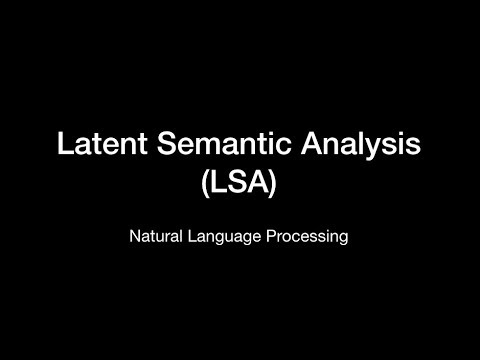

In [28]:
from IPython.display import YouTubeVideo
YouTubeVideo('OvzJiur55vo', width=1024, height=576)

### First an example

Before we apply Latent Semantic Analysis in a pipeline, let's work through a simple example together in order to better understand how LSA works and develop an intuition along the way. 

First, if you haven't already, watch the short video provided above. We will be implementing the example from the video in our notebook. 

In [29]:
# Import

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

svd = TruncatedSVD(n_components=2, # number of topics to generate (also the size of the new feature space)
                   algorithm='randomized',
                   n_iter=10)

# let's use the same data that was used in the video for consistancy 

        # topic 1 data 
data = ["pizza", 
        "pizza hamberger cookie",
        "hamberger", 
        # topic 2 data
        "ramen", 
        "sushi", 
        "ramen sushi"]

In [30]:
# CREATE Term-Frequency matrix a.k.a. term-doc matrix 

tf_vect = CountVectorizer()
tfm = tf_vect.fit_transform(data)
tfm = pd.DataFrame(data=tfm.toarray(), columns=tf_vect.get_feature_names())
tfm.index = data

In [33]:
tfm

,cookie,hamberger,pizza,ramen,sushi
pizza,0,0,1,0,0
pizza hamberger cookie,1,1,1,0,0
hamberger,0,1,0,0,0
ramen,0,0,0,1,0
sushi,0,0,0,0,1
ramen sushi,0,0,0,1,1


In [34]:
# Use SVD to transform our Term-Frequency matrix into a Topic matrix with reduced dimensionality

X_reduced = svd.fit_transform(tfm)

In [38]:
X_reduced.round(2)

array([[ 0.63, -0.  ],
       [ 1.72,  0.  ],
       [ 0.63, -0.  ],
       [ 0.  ,  0.71],
       [ 0.  ,  0.71],
       [ 0.  ,  1.41]])

In [39]:
topic_cols = ["topic_1", "topic_2"]
doc_topic_matrix = pd.DataFrame(data=X_reduced.round(2), columns=topic_cols)
doc_topic_matrix.index = data

In [40]:
doc_topic_matrix

,topic_1,topic_2
pizza,0.63,-0.00
pizza hamberger cookie,1.72,0.00
hamberger,0.63,-0.00
ramen,0.00,0.71
sushi,0.00,0.71
ramen sushi,0.00,1.41


In [42]:
doc_topic_matrix.columns = ["American Food", "Japanese Food"]

In [43]:
doc_topic_matrix

,American Food,Japanese Food
pizza,0.63,-0.00
pizza hamberger cookie,1.72,0.00
hamberger,0.63,-0.00
ramen,0.00,0.71
sushi,0.00,0.71
ramen sushi,0.00,1.41


Ok, now that we have gone through an example of applying LSA on a small dataset, let's apply it in a model building pipeline. 

In [45]:
# build a pipeline, incorporate SVD, and run a gridsearch 

# create pipeline components
svd = TruncatedSVD()
rfc = RandomForestClassifier()
tfidf = TfidfVectorizer(stop_words="english")

# create pipeline objects
lsa = Pipeline([("vect", tfidf),
                ("svd", svd)])

pipe = Pipeline([("lsa", lsa),
                 ("clf", rfc)])

# create param dict
params = {
    "lsa__vect__max_df":[1.0, .95],
    "lsa__svd__n_components": [10, 100, 250], 
    "clf__n_estimators":[10, 100, 1000]
    
}

# create gridsearch object
gs = GridSearchCV(pipe, params, cv=3, n_jobs=-2, verbose=2)

# run gs
gs.fit(X_clean, Y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-2)]: Done  54 out of  54 | elapsed:   42.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('lsa',
                                        Pipeline(memory=None,
                                                 steps=[('vect',
                                                         TfidfVectorizer(analyzer='word',
                                                                         binary=False,
                                                                         decode_error='strict',
                                                                         dtype=<class 'numpy.float64'>,
                                                                         encoding='utf-8',
                                                                         input='content',
                                                                         lowercase=True,
                                                                         max_df=1.

In [46]:
gs.best_params_

{'clf__n_estimators': 100,
 'lsa__svd__n_components': 100,
 'lsa__vect__max_df': 1.0}

In [47]:
# accuracy score 
gs.best_score_

0.869656622284513

## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

# Overview

In [48]:
import spacy
import pandas as pd

# build a model that is trained on word vectors 

# load in pre-trained w2v model 
nlp = spacy.load("en_core_web_lg")

In [49]:
# load in data
train = pd.read_csv("./Kaggle Data/train.csv")
test  = pd.read_csv("./Kaggle Data/test.csv")

In [50]:
train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [51]:
test.head()

,id,description
0,3461,\nStyle: Speyside single malt scotch Color: Wa...
1,2604,"\nVery bright and lively, with a nice balance ..."
2,3341,\nA new oloroso-forward Chivas positioned to s...
3,3764,\nAged in bourbon casks and then enhanced in R...
4,2306,\nThere is a freshness to the wood on the nose...


In [52]:
# create function that returns context vectors 
def get_word_vectors(docs):
    """
    This serves as both our tokenizer and vectorizer.
    Returns a list of (averaged) word vectors, i.e. our doc-term matrix 
    """
    
    return [nlp(doc).vector  for doc in docs ]

In [55]:
# clean text data 
train["clean_text"] = train.description.apply(clean_data)
test["clean_text"] = test.description.apply(clean_data)

In [57]:
# move clean text data to arrays 
X_train = train["clean_text"].values
X_test = test["clean_text"].values

In [58]:
# create train/test vectors 
X_train_vect = get_word_vectors(X_train)
X_test_vect = get_word_vectors(X_test)

In [60]:
# move training labels to array 
Y_train = train.ratingCategory.values

In [61]:
rfc = RandomForestClassifier(oob_score=True) 

In [62]:
rfc.fit(X_train_vect, Y_train)

/Users/alexanderbarriga/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexanderbarriga/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexanderbarriga/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
# training accracy on fitted model 
rfc.score(X_train_vect, Y_train)

0.990457548323954

In [67]:
# out-of-bag score (think of it as a test set score)
rfc.oob_score_

0.6398336187912894

## Follow Along

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Review

To review this module: 
* Continue working on the Kaggle competition
* Find another text classification task to work on